In [1]:
# common libraries
import sys, glob, random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# analysis related modules
from scipy.stats import entropy, spearmanr
from scipy import interp
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, roc_curve, auc, r2_score
from sklearn.model_selection import KFold, GroupKFold
from collections import Counter

In [3]:
# keras modules
import tensorflow as tf
# from keras.models import load_model

from bert.tokenization import FullTokenizer

# from keras.preprocessing.text import text_to_word_sequence, Tokenizer
# from keras.preprocessing.sequence import pad_sequences

# from keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.utils import plot_model
import keras_tqdm
from livelossplot.keras import PlotLossesCallback

/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sjnam/anacond

In [4]:
# custom layers from external files
from layers.embeddings import BertLayer
from layers.attention import AttentionLayer
from models.build_models import *
from models.train_models import *
from utils.utils import *

In [5]:
# some option settings for Jupyter notebook and TF
%load_ext autoreload
%autoreload 2
pd.set_option('display.max_colwidth', -1)
tf.logging.set_verbosity(tf.logging.ERROR)

In [6]:
# import spacy

In [7]:
df_contexts = pd.read_pickle('dataset/predicting_contextual_informativeness-master/kapelner_context.pickle')

In [8]:
df_contexts.head()

,context_id,context,target_word,band,mean_rating,inappropriate_count,collocation_1_10,collocation_11_20,collocation_21_50,collocation_51_100,...,AWL Sublist 6 Normed,AWL Sublist 7 Normed,AWL Sublist 8 Normed,AWL Sublist 9 Normed,AWL Sublist 10 Normed,All AFL Normed,Core AFL Normed,Spoken AFL Normed,Written AFL Normed,dataset
0,1564,"The book Manipur: A Tourist Paradise is a unique milestone of tourism. It reveals that Manipur has unlimited untapped potential for the development of tourism in terms of exotic scenic natural beauty, fascinating wild life, salubrious climate and mosaic of enchanting cultures. It properly conceived and executed, it will prove to b of immense benefit to the state.",salubrious,9,2.70,0,0.0,0.0,0.0,1.0,...,0.017241,0.017241,0.0,0.0,0.017241,0.034483,0.034483,0.0,0.0,1
1,1566,"Although as Billy Bragg, who knows a thing or two about the subject, once observed ""All the great political music was made at the height of political confrontations"", the relationship between music and politics has proven to be a much more salubrious one than the one between money and politics, the subject of our Cover Story this week. ...",salubrious,9,2.67,2,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.015152,0.015152,0.0,0.0,1
2,1571,"Self honor is how self views himself or herself, either salutary or horrible. An individual who has a salubrious oneself esteem is one who views things in a substantive way. Although self esteem improvement should typically start from childhood, it is never too late to set right past mistakes and try to propagate this in adulthood.",salubrious,9,2.10,2,0.0,0.0,0.0,0.0,...,0.000000,0.017857,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,1
3,1580,"As with ginger, turmeric has salubrious properties. It is an antiseptic, applied as a paste to cuts and abrasions, and is taken with food to purify the blood and aid digestion. Hindus consider it sacred and the women will mark a dot of it on each other's foreheads as a mark of respect and friendship.",salubrious,9,3.22,2,0.0,0.0,0.0,0.0,...,0.000000,0.018182,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,1
4,1581,"The city of Bangalore has acquired a unique status in the country today. Once known for its salubrious climate and beautiful gardens, Bangalore is now emerging as a hub of commercial, industrial and IT activity. Globally known MNCs from IT to Biotechnology, from Engineering to Finance, from Automotive to Pharma have set up their offices in Bangalore. ...",salubrious,9,2.70,0,0.0,0.0,1.0,1.0,...,0.000000,0.022727,0.0,0.0,0.000000,0.011364,0.011364,0.0,0.0,1


In [9]:
df_contexts['context'][0]

'The book Manipur: A Tourist Paradise is a unique milestone of tourism. It reveals that Manipur has unlimited untapped potential for the development of tourism in terms of exotic scenic natural beauty, fascinating wild life, salubrious climate and mosaic of enchanting cultures. It properly conceived and executed, it will prove to b of immense benefit to the state.'

In [10]:
# nlp = spacy.load("en_core_web_sm")
# doc = nlp("This is a sentence. This is another sentence.")
# for sent in doc.sents:
#     print(sent.text)

# [CLS] xxx. [SEP] xxx. [SEP]
# tt = nlp(df_contexts['context'][0])
# tt2 = '[CLS] '
# for sent in tt.sents:
#     tt2 += sent.text.replace('.', ' [SEP] ')
# #     print(sent.text)

# tt2

In [11]:
def proc_sentences_EVALution_bert(df, col_sentence, col_targ, mod_type):
    sentences = []
    li_targ = []
    li_sent = []
    for i in range(df.shape[0]):
        sent = df.iloc[i][col_sentence]
        targ = df.iloc[i][col_targ]
        li_targ.append(targ)
        li_sent.append(sent)
    sentences = [np.array(li_targ), np.array(li_sent)]
    return(sentences)   


In [12]:
sentences = proc_sentences_EVALution_bert(df_contexts, 'context', 'target_word', 'bert')

In [13]:
mm_scaler = MinMaxScaler()
info_scores = mm_scaler.fit_transform(df_contexts[['mean_rating']])
info_scores = info_scores[:,0]

In [14]:
info_scores

array([0.675 , 0.6675, 0.525 , ..., 0.625 , 0.7825, 0.425 ])

In [18]:
# gkf = GroupKFold(n_splits=K_FOLDS)
# gkf_split = gkf.split(sentences[1], groups=sentences[0])

# gkf_train_idx = []
# gkf_test_idx = []
# for train_idx, test_idx in gkf_split:
#     gkf_train_idx.append(train_idx)
#     gkf_test_idx.append(test_idx)

# train_idx0 = gkf_train_idx[0]
# test_idx0 = gkf_test_idx[0]

# sentences_train = [sent[train_idx0] for sent in sentences]
# sentences_test  = [sent[test_idx0] for sent in sentences]
# info_scores_train = info_scores[train_idx0]
# info_scores_test  = info_scores[test_idx0]

# MAX_SEQ_LEN = 150
# tokenizer = create_tokenizer_from_hub_module()
# train_examples = convert_text_to_examples(sentences_train[0], sentences_train[1], info_scores_train)
# test_examples  = convert_text_to_examples(sentences_test[0],  sentences_test[1],  info_scores_test)
# (train_input_ids, train_input_masks, train_targ_locs, train_segment_ids, train_scores) = convert_examples_to_features(tokenizer, train_examples, False, MAX_SEQ_LEN)
# (test_input_ids,  test_input_masks, test_targ_locs, test_segment_ids,  test_scores)  = convert_examples_to_features(tokenizer, test_examples, False, MAX_SEQ_LEN)
# # TODO: multi sentence segmentations; targ!=targ_in_sent lexical form

# BERT + Attention model

## separate targ-cntx layers

In [28]:
MAX_SEQ_LEN = 150

K.clear_session()
sess = tf.Session()

model_bert = build_model_bert(MAX_SEQ_LEN, finetune_emb=True, attention_layer=True, sep_cntx_targ=False)
initialize_vars(sess)

model_bert.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 150)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 150)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 150)]        0                                            
__________________________________________________________________________________________________
bert_sent_raw (BertLayer)       (None, None, 768)    107719680   input_ids[0][0]                  
                                                                 input_masks[0][0]            

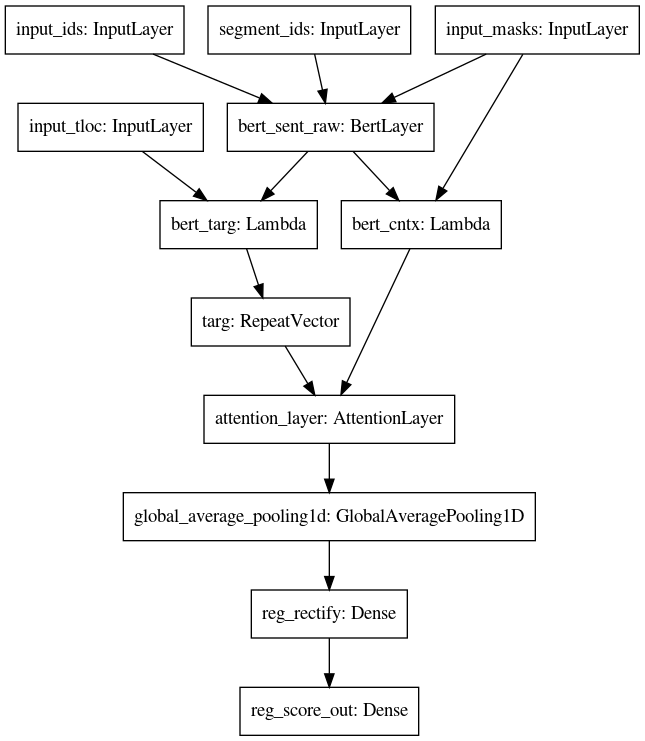

In [29]:
plot_model(model_bert)

In [29]:
_num_iter = 2
_batch_size = 16
K_FOLDS = 10

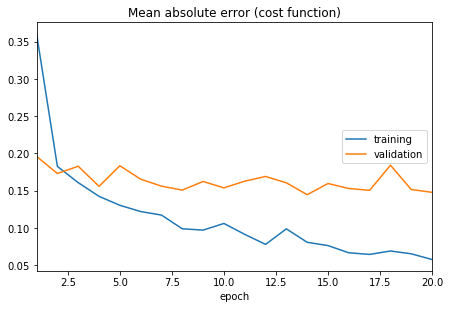

Mean absolute error (cost function):
training   (min:    0.057, max:    0.361, cur:    0.057)
validation (min:    0.144, max:    0.196, cur:    0.148)



In [21]:
gkf = GroupKFold(n_splits=K_FOLDS)
gkf_split = gkf.split(sentences[1], groups=sentences[0])
train_bertmod_cv(sentences, info_scores, False,
                 gkf_split, True, True, False,
                 "./model_weights_kapelner/bert/1emb/model_bert_notarg_wtattn_cvTwrd.h5",
                 "./model_predict_kapelner/bert/1emb/preds_bert_notarg_wtattn_cvTwrd.npy",
                 MAX_SEQ_LEN, NUM_ITER, BATCH_SIZE)

In [35]:
model_bert.fit(x=[train_input_ids, train_input_masks, train_targ_locs, train_segment_ids], y=train_scores, 
         epochs=_num_iter, batch_size=_batch_size, 
         validation_split=0.10, shuffle=True,
         verbose=0, 
         callbacks=[keras_tqdm.TQDMNotebookCallback(leave_inner=False, leave_outer=True)])

In [36]:
model_bert.save_weights("./model_weights_kapelner/model_bert_notarg_wtattn.h5")

In [37]:
# prediction
pred_test = np.reshape(model_bert.predict([test_input_ids, test_input_masks, test_targ_locs, test_segment_ids], batch_size=_batch_size), -1)
np.save("./model_predict_kapelner/preds_bert_notarg_wtattn.npy", pred_test)

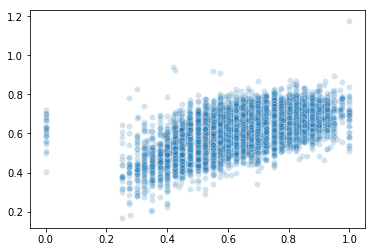

In [39]:
sns.scatterplot(test_scores[:,0], pred_test, alpha=0.2)

In [41]:
spearmanr(test_scores[:,0], pred_test)

SpearmanrResult(correlation=0.5365336262146646, pvalue=0.0)

In [45]:
r2_score(test_scores[:,0], pred_test)

0.26970139889356803

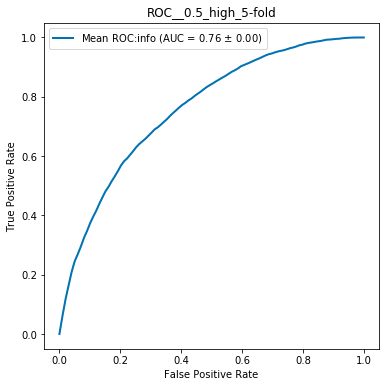

In [52]:
fig, axes = plt.subplots(ncols=1, figsize=(6, 6))
tt_col = sns.color_palette("colorblind", 6)

roc_cv([test_scores[:,0]], "model_predict_kapelner/preds_bert_notarg_wtattn*", "info", 0.5, "high", fig, axes, tt_col[0], "-")

# Predicting DSCoVAR sentences with Kapelner et al. model 

In [19]:
df_cloze = pd.read_pickle('./dataset/cloze_df_scores_all3.pickle')

In [20]:
df_cloze.head()

,Unnamed: 0,index,cloze_resp,sentID_GM,sentence,targ,targ_POS,cloze_resp_len,ent_elmo,ent_cloze,...,scores_avg_rank,elmo_score,sent_len,targ_loc,targ_loc_before,targ_loc_end,targ_loc_rel,syn1,syn2,syn3
0,0,0,"{'fight': 8, 'rift': 6, 'wall': 2, 'wedge': 1, 'divide': 1, 'disagreement': 1, 'argument': 1, 'resentment': 1, 'chasm': 1, 'battle': 1, 'rivalry': 1, 'grudge': 1, 'third': 1, 'enmity': 1, 'split': 1, 'problem': 1, 'conflict': 1}",{1547},A ______ emerged between the two who were once friends .,discord,NN,[30],2.246163,2.442118,...,678.5,0.594419,11,1,9,False,0.090909,conflict,strife,fighting
1,1,1,"{'happy': 6, 'unconventional': 2, 'simple': 2, 'peaceful': 2, 'wild': 2, 'adventurous': 2, 'fun': 2, 'whimsical': 1, 'carefree': 1, 'blast': 1, 'kind': 1, 'nice': 1, 'vibrant': 1, 'adventurer': 1, 'creative': 1, 'witty': 1, 'hipster': 1, 'optimist': 1, 'loving': 1}",{518},A bohemian is a person who is free-spirited and ______ .,rakish,AJ,[30],2.232694,2.765587,...,842.0,0.542132,11,9,1,True,0.818182,hip,cool,bohemian
2,2,2,"{'stole': 13, 'stolen': 7, 'vandalized': 3, 'damaged': 2, 'tore': 1, 'ruined': 1, 'destroyed': 1, 'defaced': 1, 'defiled': 1}",{803},A bunch of kids had broken in and ______ the paintings .,defile,VB,[30],2.243330,1.679603,...,787.0,0.778024,12,8,3,False,0.666667,ruin,spoil,deface
3,3,3,"{'berate': 5, 'bully': 4, 'belittle': 3, 'insult': 3, 'push': 2, 'love': 1, 'punish': 1, 'abuse': 1, 'fear': 1, 'badger': 1, 'annoy': 1, 'criticisms': 1, 'dictatorship': 1, 'ridicule': 1, 'scold': 1, 'demoralize': 1, 'order': 1, 'mock': 1}",{747},"A coach should provide leadership, not ______ their players .",browbeat,VB,[30],2.200604,2.682186,...,1237.5,0.663644,11,7,3,False,0.636364,bully,bully,hector
4,4,4,"{'force': 4, 'get': 3, 'whip': 2, 'bring': 2, 'start': 2, 'prod': 2, 'coach': 1, 'help': 1, 'coerce': 1, 'train': 1, 'lasso': 1, 'hit': 1, 'halt': 1, 'roundup': 1, 'slow': 1, 'coax': 1, 'lead': 1, 'make': 1, 'entice': 1, 'push': 1, 'order': 1}",{875},A cowboy used a short whip to ______ his horse into a slow gallop .,goad,VB,[30],2.221154,2.921658,...,1365.5,0.663699,15,7,7,False,0.466667,nag,coerce,NaN


In [21]:
sentences_dscovar_notarg = proc_sentences_dscovar(df_cloze, 'sentence', 'targ', 'bert')

In [22]:
sentences_dscovar_notarg

[array(['discord', 'rakish', 'defile', ..., 'deviate', 'frigid', 'adhere'],
       dtype='<U12'),
 array([' A discord  emerged between the two who were once friends . ',
        ' A bohemian is a person who is free-spirited and rakish  . ',
        ' A bunch of kids had broken in and defile  the paintings . ', ...,
        ' You will not get lost if you stay straight and do not deviate  . ',
        " You'll find what you're looking for when it becomes more frigid  . ",
        " Your plan's nice, but I doubt I could adhere  to it for long . "],
       dtype='<U109')]

In [23]:
mm_scaler = MinMaxScaler()
scores_dscovar_bws = mm_scaler.fit_transform(df_cloze[['scores_sum']])
scores_dscovar_bws = scores_dscovar_bws[:,0]

/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [24]:
scores_dscovar_bws

array([0.45652174, 0.52173913, 0.5       , ..., 0.60869565, 0.43478261,
       0.58695652])

In [25]:
MAX_SEQ_LEN = 150
tokenizer = create_tokenizer_from_hub_module()
dscovar_examples = convert_text_to_examples(sentences_dscovar_notarg[0], sentences_dscovar_notarg[1], scores_dscovar_bws)
(dscovar_input_ids, dscovar_input_masks, dscovar_targ_locs, dscovar_segment_ids, dscovar_scores) = convert_examples_to_features(tokenizer, dscovar_examples, False, MAX_SEQ_LEN)


In [68]:
K.clear_session()
sess = tf.Session()

model_bert = build_model_bert(MAX_SEQ_LEN, finetune_emb=True, attention_layer=True, sep_cntx_targ=False)
initialize_vars(sess)

model_bert.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 150)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 150)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 150)]        0                                            
__________________________________________________________________________________________________
bert_sent_raw (BertLayer)       (None, None, 768)    107719680   input_ids[0][0]                  
                                                                 input_masks[0][0]            

In [69]:
model_bert.load_weights("./model_weights_kapelner/model_bert_notarg_wtattn.h5")

In [71]:
pred_dscovar_scores = np.reshape(model_bert.predict([dscovar_input_ids, dscovar_input_masks, dscovar_targ_locs, dscovar_segment_ids], batch_size=_batch_size), -1)    
np.save("./model_predict/preds_bert_Tkapelner_Pdscovar_notarg_wtattn.npy", pred_dscovar_scores)

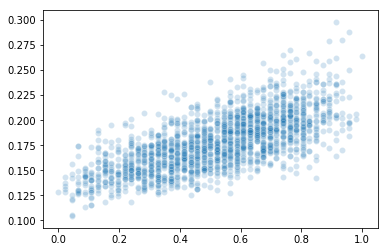

In [74]:
sns.scatterplot(dscovar_scores[:, 0], pred_dscovar_scores, alpha=0.2)

In [75]:
spearmanr(dscovar_scores[:, 0], pred_dscovar_scores)

SpearmanrResult(correlation=0.69186064924015, pvalue=3.3441000225371336e-254)

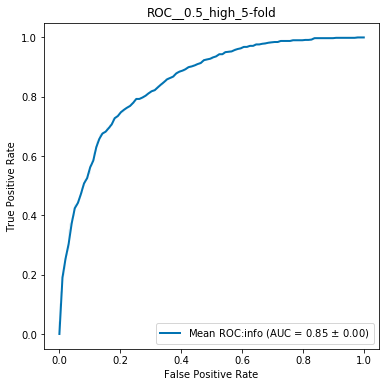

In [76]:
fig, axes = plt.subplots(ncols=1, figsize=(6, 6))
tt_col = sns.color_palette("colorblind", 6)

roc_cv([dscovar_scores[:, 0]], "./model_predict/preds_bert_Tkapelner_Pdscovar_notarg_wtattn*", "info", 0.5, "high", fig, axes, tt_col[0], "-")

# Predicting Kapelner et al. with DSCoVAR model 

In [82]:
K.clear_session()
sess = tf.Session()
plot_losses = PlotLossesCallback()

# preparing
model_bert_dscovar = build_model_bert(MAX_SEQ_LEN, finetune_emb=True, attention_layer=True, sep_cntx_targ=False)
initialize_vars(sess)

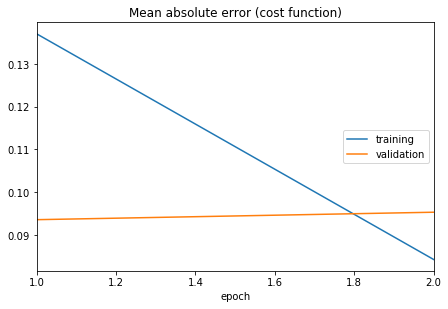

Mean absolute error (cost function):
training   (min:    0.084, max:    0.137, cur:    0.084)
validation (min:    0.094, max:    0.095, cur:    0.095)



In [83]:
# training
model_bert_dscovar.fit(x=[dscovar_input_ids, dscovar_input_masks, dscovar_targ_locs, dscovar_segment_ids], 
                       y=dscovar_scores, 
         epochs=_num_iter, batch_size=_batch_size, 
         validation_split=0.10, shuffle=True,
         verbose=0, 
         callbacks=[keras_tqdm.TQDMNotebookCallback(leave_inner=False, leave_outer=True), 
                    plot_losses])

In [84]:
model_bert_dscovar.save_weights("./model_weights/model_bert_Tdscovar_notarg_wtattn.h5")

In [192]:
# model_bert_dscovar.load_weights("./model_weights/model_bert_Tdscovar_notarg_wtattn.h5")

In [85]:
pred_scores = model_bert_dscovar.predict([test_input_ids, test_input_masks, test_targ_locs, test_segment_ids], 
                            batch_size=_batch_size, 
                            callbacks=[keras_tqdm.TQDMNotebookCallback(leave_inner=True, leave_outer=True)])
pred_scores = np.reshape(pred_scores, -1)
np.save("./model_predict_kapelner/preds_bert_Tdscovar_Pkapelner_notarg_wtattn.npy", pred_scores)

In [86]:
pred_scores = np.load("./model_predict_kapelner/preds_bert_Tdscovar_Pkapelner_notarg_wtattn.npy")

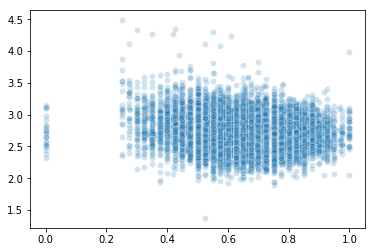

In [87]:
sns.scatterplot(test_scores[:,0], pred_scores, alpha=0.2)

In [89]:
spearmanr(test_scores[:,0], pred_scores)

SpearmanrResult(correlation=-0.09214215122815472, pvalue=6.044237142628763e-28)

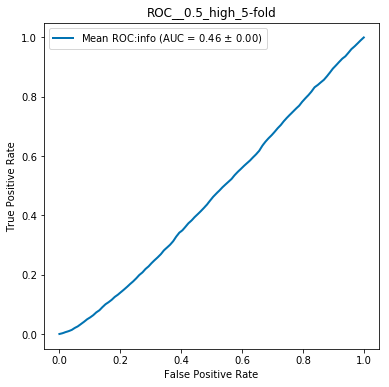

In [90]:
fig, axes = plt.subplots(ncols=1, figsize=(6, 6))
tt_col = sns.color_palette("colorblind", 6)

roc_cv([test_scores[:,0]], "./model_predict_kapelner/preds_bert_Tdscovar_Pkapelner_notarg_wtattn*", "info", 0.5, "high", fig, axes, tt_col[0], "-")

# Predicting Kapelner et al. with DSCoVAR model - cut40

In [35]:
CUT_SEQ_LEN = 20

tokenizer = create_tokenizer_from_hub_module()
dscovar_examples = convert_text_to_examples(sentences_dscovar_notarg[0], sentences_dscovar_notarg[1], scores_dscovar_bws)
(dscovar_input_ids, dscovar_input_masks, dscovar_targ_locs, dscovar_segment_ids, dscovar_scores) = convert_examples_to_features(tokenizer, dscovar_examples, False, CUT_SEQ_LEN*2)

In [36]:
K.clear_session()
sess = tf.Session()
plot_losses = PlotLossesCallback()

# preparing
model_bert_dscovar = build_model_bert(CUT_SEQ_LEN*2, finetune_emb=True, attention_layer=True, sep_cntx_targ=False)
initialize_vars(sess)

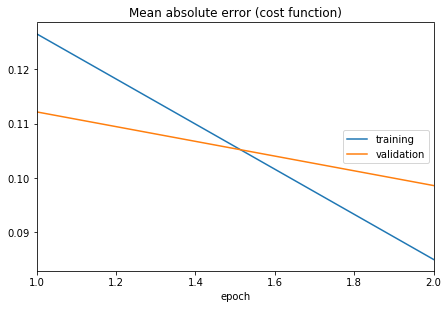

Mean absolute error (cost function):
training   (min:    0.085, max:    0.126, cur:    0.085)
validation (min:    0.099, max:    0.112, cur:    0.099)



In [38]:
# training
model_bert_dscovar.fit(x=[dscovar_input_ids, dscovar_input_masks, dscovar_targ_locs, dscovar_segment_ids], 
                       y=dscovar_scores, 
         epochs=_num_iter, batch_size=_batch_size, 
         validation_split=0.10, shuffle=True,
         verbose=0, 
         callbacks=[keras_tqdm.TQDMNotebookCallback(leave_inner=False, leave_outer=True), 
                    plot_losses])

In [39]:
model_bert_dscovar.save_weights("./model_weights/model_bert_Tdscovar_notarg_wtattn_cut40.h5")

In [40]:
# model_bert_dscovar.load_weights("./model_weights/model_bert_Tdscovar_notarg_wtattn.h5")

In [41]:
pred_scores = model_bert_dscovar.predict([test_input_ids, test_input_masks, test_targ_locs, test_segment_ids], 
                            batch_size=_batch_size, 
                            callbacks=[keras_tqdm.TQDMNotebookCallback(leave_inner=True, leave_outer=True)])
pred_scores = np.reshape(pred_scores, -1)
np.save("./model_predict_kapelner/preds_bert_Tdscovar_Pkapelner_notarg_wtattn_cut40.npy", pred_scores)

ValueError: Error when checking input: expected input_ids to have shape (40,) but got array with shape (150,)

In [86]:
pred_scores = np.load("./model_predict_kapelner/preds_bert_Tdscovar_Pkapelner_notarg_wtattn_cut40.npy")

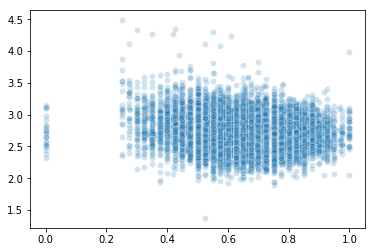

In [87]:
sns.scatterplot(test_scores[:,0], pred_scores, alpha=0.2)

In [89]:
spearmanr(test_scores[:,0], pred_scores)

SpearmanrResult(correlation=-0.09214215122815472, pvalue=6.044237142628763e-28)

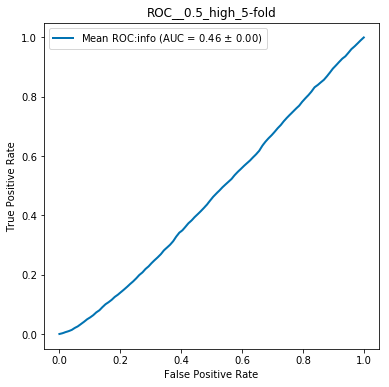

In [90]:
fig, axes = plt.subplots(ncols=1, figsize=(6, 6))
tt_col = sns.color_palette("colorblind", 6)

roc_cv([test_scores[:,0]], "./model_predict_kapelner/preds_bert_Tdscovar_Pkapelner_notarg_wtattn*", "info", 0.5, "high", fig, axes, tt_col[0], "-")